In [1]:
import sys, platform, site, pprint
print("Python:", sys.version)
print("Exe   :", sys.executable)
print("Platform:", platform.platform())
print("Site-packages:", site.getsitepackages())
try:
    import numpy as np
    print("NumPy:", np.__version__, "path:", np.__file__)
except Exception as e:
    print("NumPy import failed:", e)

Python: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:23:22) [MSC v.1944 64 bit (AMD64)]
Exe   : c:\Users\lucas\miniconda3\envs\TableOCR\python.exe
Platform: Windows-10-10.0.26100-SP0
Site-packages: ['c:\\Users\\lucas\\miniconda3\\envs\\TableOCR', 'c:\\Users\\lucas\\miniconda3\\envs\\TableOCR\\lib\\site-packages']
NumPy: 2.2.6 path: c:\Users\lucas\miniconda3\envs\TableOCR\lib\site-packages\numpy\__init__.py


In [2]:
from __future__ import annotations
from typing import Dict, List, Iterable, Optional, Tuple, Literal
import os
import json

import numpy as np
import cv2
import pymupdf
from PIL import Image, ImageOps

from skimage import transform as sktf, feature as skfeat, filters as skf, morphology as skm, measure

# my own funcs
from detect import pdf_to_images

c:\Users\lucas\miniconda3\envs\TableOCR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def _load_annotations(ann_path: str) -> dict:
    with open(ann_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    data.setdefault("meta", {})
    data.setdefault("pages", {})
    # Normalize keys to str->int mapping on the fly
    pages = {}
    for k, v in data["pages"].items():
        try:
            pages[int(k)] = v
        except Exception:
            continue
    data["pages"] = pages
    return data

In [4]:
def _scale_rect(rect: List[float], from_size: Tuple[float, float], to_size: Tuple[int, int]) -> List[int]:
    """
    Scale [x1,y1,x2,y2] from 'from_size' (W,H) to 'to_size' (W,H).
    If 'from_size' is (0,0) or missing, assume no scaling needed.
    Returns integer pixel coords clamped to destination size.
    """
    x1, y1, x2, y2 = map(float, rect)
    fW, fH = from_size
    tW, tH = to_size
    if fW and fH and (abs(fW - tW) > 1e-3 or abs(fH - tH) > 1e-3):
        sx = tW / fW
        sy = tH / fH
        x1 *= sx; x2 *= sx
        y1 *= sy; y2 *= sy

    # normalize + clamp
    x1i, x2i = sorted((int(round(x1)), int(round(x2))))
    y1i, y2i = sorted((int(round(y1)), int(round(y2))))
    x1i = max(0, min(x1i, tW))
    x2i = max(0, min(x2i, tW))
    y1i = max(0, min(y1i, tH))
    y2i = max(0, min(y2i, tH))
    return [x1i, y1i, x2i, y2i]

In [5]:
def _resize_normalized(
    img: Image.Image,
    output_size: Tuple[int, int],
    mode: Literal["stretch", "fit", "fill"] = "fit",
    fill_color: Tuple[int, int, int] = (255, 255, 255),
    resample: int = Image.BICUBIC,
) -> Image.Image:
    """
    Resize 'img' to EXACTLY output_size according to 'mode':
      - stretch: direct resize (may distort)
      - fit: letterbox padding to preserve aspect (ImageOps.pad-like but without cropping)
      - fill: cover + center-crop (like ImageOps.fit)
    """
    Wt, Ht = output_size
    if mode == "stretch":
        return img.resize((Wt, Ht), resample=resample)

    if mode == "fit":
        # Scale to fit within target, then pad to exact size
        fitted = ImageOps.contain(img, (Wt, Ht), method=resample)
        canvas = Image.new("RGB" if fitted.mode != "RGBA" else "RGBA", (Wt, Ht), fill_color)
        x = (Wt - fitted.width) // 2
        y = (Ht - fitted.height) // 2
        canvas.paste(fitted, (x, y))
        return canvas

    if mode == "fill":
        # Scale to cover target, then center-crop to exact size
        return ImageOps.fit(img, (Wt, Ht), method=resample, centering=(0.5, 0.5))
    
    raise ValueError(f"Unknown resize mode: {mode}")

In [6]:
def extract_annotated_regions(
    pdf_path: str,
    ann_path: str,
    render_dpi: Optional[int] = None,
    pages: Optional[Iterable[int]] = None,
    save_dir: Optional[str] = None,
    color: bool = True,
    output_size: Optional[Tuple[int, int]] = None,     # <— NEW
    resize_mode: Literal["stretch","fit","fill"] = "fit",  # <— NEW
    fill_color: Tuple[int, int, int] = (255, 255, 255),    # <— NEW (for padding)
    resample: int = Image.BICUBIC,                          # <— NEW
) -> Dict[int, List[Image.Image]]:
    """
    Create cropped PIL Images for each annotated rectangle.
    If output_size is provided, each crop is converted to that exact size
    using the specified resize_mode.
    """
    ann = _load_annotations(ann_path)
    meta_dpi = ann.get("meta", {}).get("dpi", None)
    dpi = int(render_dpi or (meta_dpi if meta_dpi else 300))

    pil_pages = pdf_to_images(pdf_path, pages=pages, dpi=dpi, color=color)

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    out: Dict[int, List[Image.Image]] = {}
    for p, img in pil_pages.items():
        W, H = img.size
        page_info = ann["pages"].get(p, {})
        src_size = page_info.get("size", [0.0, 0.0])
        try:
            srcW, srcH = float(src_size[0]), float(src_size[1])
        except Exception:
            srcW, srcH = 0.0, 0.0
        rects = page_info.get("rects", [])

        crops: List[Image.Image] = []
        for i, rect in enumerate(rects):
            x1, y1, x2, y2 = _scale_rect(rect, (srcW, srcH), (W, H))
            if x2 - x1 <= 1 or y2 - y1 <= 1:
                continue
            crop = img.crop((x1, y1, x2, y2))

            if output_size is not None:
                crop = _resize_normalized(
                    crop,
                    output_size=output_size,
                    mode=resize_mode,
                    fill_color=fill_color,
                    resample=resample,
                )

            crops.append(crop)

            if save_dir is not None:
                suffix = f"{resize_mode}_{output_size[0]}x{output_size[1]}" if output_size else "orig"
                crop_path = os.path.join(save_dir, f"page_{p+1:03d}_region_{i+1:02d}_{suffix}.png")
                crop.save(crop_path)

        out[p] = crops
    return out

In [7]:
tables = extract_annotated_regions(pdf_path='1880.pdf',ann_path='1880_annotations.json',render_dpi=300,output_size=(1000,1200))

In [8]:
# ---------------------------
# Utilities
# ---------------------------
def pil_to_cv(img: Image.Image) -> np.ndarray:
    if img.mode in ("RGB", "RGBA"):
        arr = np.array(img.convert("RGB"))
        return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
    elif img.mode == "L":
        return np.array(img)
    else:
        arr = np.array(img.convert("RGB"))
        return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)

def cv_to_pil(img: np.ndarray) -> Image.Image:
    if img.ndim == 2:
        return Image.fromarray(img)
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def ensure_gray(img_bgr: np.ndarray) -> np.ndarray:
    return img_bgr if img_bgr.ndim == 2 else cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

def resize_keep(img: np.ndarray, size: Tuple[int,int]) -> np.ndarray:
    return cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)

In [9]:
# ---------------------------
# Method 1: ORB + Homography
# ---------------------------
def register_homography(
    src_pil: Image.Image,
    ref_pil: Image.Image,
    out_size: Tuple[int, int],
    n_features: int = 3000,
    ratio_thresh: float = 0.75,
) -> Image.Image:
    src = pil_to_cv(src_pil)
    ref = pil_to_cv(ref_pil)

    src_gray = ensure_gray(src)
    ref_gray = ensure_gray(ref)

    # ORB features
    orb = cv2.ORB_create(nfeatures=n_features, fastThreshold=5, edgeThreshold=5)
    kps1, des1 = orb.detectAndCompute(src_gray, None)
    kps2, des2 = orb.detectAndCompute(ref_gray, None)
    if des1 is None or des2 is None:
        # fall back: just resize
        return cv_to_pil(resize_keep(src, out_size))

    # BF matcher + Lowe ratio test
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)

    if len(good) < 8:
        return cv_to_pil(resize_keep(src, out_size))

    src_pts = np.float32([kps1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kps2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)
    if H is None:
        return cv_to_pil(resize_keep(src, out_size))

    warped = cv2.warpPerspective(src, H, (ref.shape[1], ref.shape[0]), flags=cv2.INTER_CUBIC)
    return cv_to_pil(resize_keep(warped, out_size))

In [10]:
# ---------------------------
# Method 2: ECC (affine/homography)
# ---------------------------
def register_ecc(
    src_pil: Image.Image,
    ref_pil: Image.Image,
    out_size: Tuple[int, int],
    warp_mode: Literal["affine","homography"] = "affine",
    n_iter: int = 300,
    eps: float = 1e-6,
) -> Image.Image:
    src = pil_to_cv(src_pil)
    ref = pil_to_cv(ref_pil)
    src_gray = ensure_gray(src)
    ref_gray = ensure_gray(ref)

    # Normalize contrast to help ECC
    src_gray = cv2.normalize(src_gray, None, 0, 255, cv2.NORM_MINMAX)
    ref_gray = cv2.normalize(ref_gray, None, 0, 255, cv2.NORM_MINMAX)

    if warp_mode == "homography":
        warp_matrix = np.eye(3, dtype=np.float32)
        motion_type = cv2.MOTION_HOMOGRAPHY
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        motion_type = cv2.MOTION_AFFINE

    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, n_iter, eps)

    try:
        cc, warp_matrix = cv2.findTransformECC(
            ref_gray, src_gray, warp_matrix, motion_type, criteria, None, 5
        )
    except cv2.error:
        return cv_to_pil(resize_keep(src, out_size))

    if motion_type == cv2.MOTION_HOMOGRAPHY:
        aligned = cv2.warpPerspective(src, warp_matrix, (ref.shape[1], ref.shape[0]),
                                      flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP)
    else:
        aligned = cv2.warpAffine(src, warp_matrix, (ref.shape[1], ref.shape[0]),
                                 flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP)

    return cv_to_pil(resize_keep(aligned, out_size))


In [11]:
# ---------------------------
# Method 3: Piecewise-affine via grid intersections
# ---------------------------
def _grid_intersections(img_gray: np.ndarray) -> np.ndarray:
    """
    Heuristic: binarize, extract horizontal/vertical lines, find intersections.
    Returns Nx2 array of (x, y) points.
    """
    # Adaptive threshold
    th = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, 21, 15)

    # Separate horizontal/vertical via morphology
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))

    horiz = cv2.morphologyEx(th, cv2.MORPH_OPEN, h_kernel, iterations=1)
    vert  = cv2.morphologyEx(th, cv2.MORPH_OPEN, v_kernel, iterations=1)

    # intersections ~ AND of dilated lines
    inter = cv2.bitwise_and(cv2.dilate(horiz, None, iterations=1),
                            cv2.dilate(vert, None, iterations=1))

    # Find connected components centroids
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(inter, connectivity=8)
    pts = centroids[1:] if num > 1 else np.zeros((0, 2), dtype=np.float32)  # skip background
    return pts.astype(np.float32)


def register_piecewise(
    src_pil: Image.Image,
    ref_pil: Image.Image,
    out_size: Tuple[int, int],
    min_points: int = 12,
) -> Image.Image:
    """
    Estimates a piecewise-affine warp using detected grid intersections as control points.
    Points are matched by sorting in Morton/Z-order after coarse normalization.
    Handles mild "wavy" bends better than a single homography.
    """
    src = pil_to_cv(src_pil)
    ref = pil_to_cv(ref_pil)
    src_g = ensure_gray(src)
    ref_g = ensure_gray(ref)

    src_pts = _grid_intersections(src_g)
    ref_pts = _grid_intersections(ref_g)

    if len(src_pts) < min_points or len(ref_pts) < min_points:
        # Fallback to homography if we don't have enough structure
        return register_homography(src_pil, ref_pil, out_size)

    # Normalize to [0,1] for coarse layout-based matching
    def norm(pts, w, h): return np.column_stack((pts[:,0] / w, pts[:,1] / h))
    sN = norm(src_pts, src.shape[1], src.shape[0])
    rN = norm(ref_pts, ref.shape[1], ref.shape[0])

    # Sort by Morton order to produce deterministic correspondences
    def morton_key(xy):
        x, y = (xy * 1024).astype(int)
        def part1by1(n):
            n = (n | (n << 8)) & 0x00FF00FF
            n = (n | (n << 4)) & 0x0F0F0F0F
            n = (n | (n << 2)) & 0x33333333
            n = (n | (n << 1)) & 0x55555555
            return n
        return part1by1(x) | (part1by1(y) << 1)

    s_idx = np.argsort([morton_key(p) for p in sN])
    r_idx = np.argsort([morton_key(p) for p in rN])

    # Pair the first K points
    K = min(len(s_idx), len(r_idx))
    s_sel = src_pts[s_idx[:K]]
    r_sel = ref_pts[r_idx[:K]]

    # Piecewise affine (skimage)
    tform = sktf.PiecewiseAffineTransform()
    # skimage expects (row, col) = (y, x)
    tform.estimate(src=s_sel[:, ::-1], dst=r_sel[:, ::-1])

    warped = sktf.warp(src, inverse_map=tform, output_shape=(ref.shape[0], ref.shape[1]), order=3)
    warped_u8 = (np.clip(warped, 0, 1) * 255).astype(np.uint8)
    if warped_u8.ndim == 2:
        warped_u8 = cv2.cvtColor(warped_u8, cv2.COLOR_GRAY2BGR)
    return cv_to_pil(resize_keep(warped_u8, out_size))



In [12]:
# ---------------------------
# Orchestration
# ---------------------------
def normalize_tables(
    crops: Dict[int, List[Image.Image]],
    template: Optional[Image.Image] = None,
    out_size: Tuple[int, int] = (800, 800),
    method: Literal["homography","ecc","piecewise"] = "homography",
    save_dir: Optional[str] = None,
) -> Dict[int, List[Image.Image]]:
    """
    Normalize (deskew/dewarp) each table crop to a consistent size and layout.

    Args:
        crops: {page_idx: [PIL.Image, ...]} table crops.
        template: a reference crop (PIL.Image). If None, first crop becomes the template.
        out_size: width, height of normalized output.
        method: 'homography' (fast, robust), 'ecc' (intensity), or 'piecewise' (handles wavy grids).
        save_dir: optional folder to save normalized images.

    Returns:
        {page_idx: [PIL.Image, ...]} normalized crops.
    """
    # choose template
    if template is None:
        for lst in crops.values():
            if lst:
                template = lst[0]
                break
    if template is None:
        return {k: [] for k in crops.keys()}

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    out: Dict[int, List[Image.Image]] = {}
    for p, lst in crops.items():
        norm_list: List[Image.Image] = []
        for i, img in enumerate(lst):
            if method == "ecc":
                ni = register_ecc(img, template, out_size, warp_mode="affine")
            elif method == "piecewise":
                ni = register_piecewise(img, template, out_size)
            else:
                ni = register_homography(img, template, out_size)

            norm_list.append(ni)
            if save_dir:
                ni.save(os.path.join(save_dir, f"page_{p+1:03d}_tbl_{i+1:02d}_{method}.png"))
        out[p] = norm_list
    return out

In [13]:
tables_norm = normalize_tables(crops=tables,method='homography')

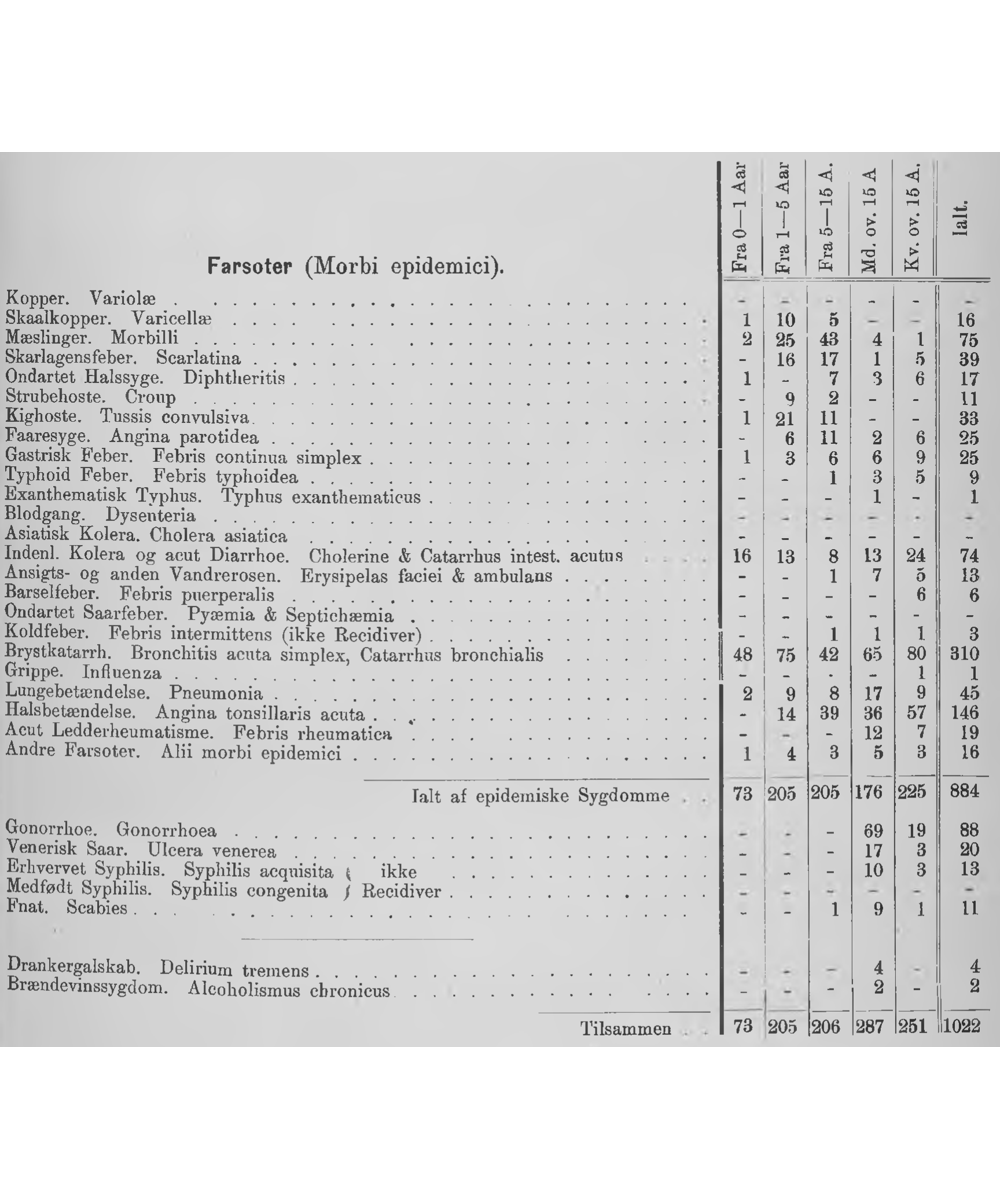

In [24]:
tables[4][0]

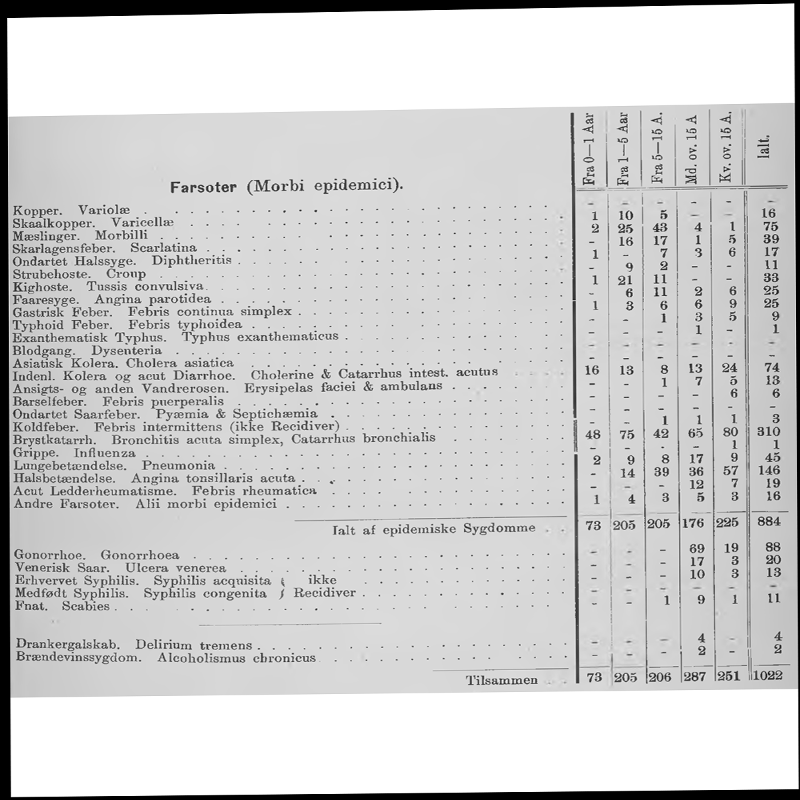

In [23]:
tables_norm[4][0]